### ============================
### Core RAG Concepts
###  ============================

###  1. Indexing:
###  A pipeline that ingests data from a source (e.g., PDFs, web pages, databases),
###  processes it, and stores it in an index (usually a vector database).
###  This step typically runs as a separate, offline process.

###  2. Retrieval and Generation:
###  The real-time RAG workflow that:
###  - Takes the user query at runtime
###  - Retrieves the most relevant data from the indexed source
###  - Passes the retrieved context to the language model
###  - Generates the final response


In [1]:
print("hello world")

hello world


Setup

In [2]:
from dotenv import load_dotenv
import os

load_dotenv() 

True

In [3]:
! pip install langchain langchain-text-splitters langchain-community bs4

  Using cached langchain_text_splitters-1.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
  Using cached pyyaml-6.0.3-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached langgraph_checkpoint-3.0.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached xxhash-3.6.0-cp313-cp313-win_amd64.whl.metadata (13 kB)
  Using cached ormsgpack-1.12.0-cp313-cp313-win_amd64.whl.metadata (1.2 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached langchain_classic-1.0.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached sqlalchemy-2.0.44-cp313-cp313-win_amd64.whl.metadata (9.8 kB)

In [4]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [5]:
! pip install langsmith langchain-groq

  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)

   ------------- -------------------------- 1/3 [groq]
   ---------------------------------------- 3/3 [langchain-groq]



Components

1. Select the model 

In [6]:
from langchain_groq import ChatGroq
model = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

2. Select an embeddings model

In [ ]:
! pip install -qU langchain-huggingface

In [9]:
! pip install sentence-transformers

  Using cached sentence_transformers-5.1.2-py3-none-any.whl.metadata (16 kB)
  Using cached torch-2.9.1-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.16.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached regex-2025.11.3-cp313-cp313-win_amd64.whl.metadata (41 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached markupsafe-3.0.3-cp313-cp313-win_amd64.whl.metadata (2.8 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached sentence_transformers-5.1.2-py3-none-any.whl (488 kB)
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
    ---------------------

In [10]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

c:\Users\indroneel\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\indroneel\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\indroneel\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to act

3. Select a vector store

In [12]:
! pip install -qU langchain-chroma

In [13]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

### ============================
### Indexing Pipeline (RAG)
### ============================

### Load:
### Load raw data from different sources (PDFs, web pages, text files, databases)
### using Document Loaders.

### Split:
### Break large documents into smaller text chunks using text splitters.
### This helps with better search and fits content into the model’s context window.

### Store:
### Store and index the text chunks using a VectorStore and an Embeddings model
### so they can be efficiently searched later.



Loading documents

In [14]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43047


In [15]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


Splitting documents

## Handling Long Documents

Our loaded document is over 42k characters which is too long to fit into the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

To handle this we'll split the `Document` into chunks for embedding and vector storage. This should help us retrieve only the most relevant parts of the blog post at run time.

we use a `RecursiveCharacterTextSplitter`, which will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.

In [16]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


Storing documents

In [17]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['7622ffd1-0b33-4440-b9a6-706c5a9e94e8', '61e1d2e8-7448-43a9-9c3c-82fe177bbdd1', '9f1898b3-1961-49b1-ae88-0d8d51cf9f16']


Retrieval and Generation

## How RAG Applications Work

RAG applications commonly work as follows:

1. **Retrieve:** Given a user input, relevant splits are retrieved from storage using a Retriever.
2. **Generate:** A model produces an answer using a prompt that includes both the question with the retrieved data


RAG agents

In [19]:
from langchain.tools import tool

@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve information to help answer a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [20]:
from langchain.agents import create_agent


tools = [retrieve_context]
# If desired, specify custom instructions
prompt = (
    "You have access to a tool that retrieves context from a blog post. "
    "Use the tool to help answer user queries."
)
agent = create_agent(model, tools, system_prompt=prompt)

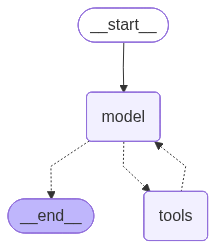

In [21]:
agent

In [22]:
query = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

c:\Users\indroneel\miniconda3\Lib\site-packages\langsmith\client.py:297: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (fc_647cf5b2-0d95-4319-babc-3877708c6ea4)
 Call ID: fc_647cf5b2-0d95-4319-babc-3877708c6ea4
  Args:
    query: standard method for Task Decomposition common extensions
================================= Tool Message =================================
Name: retrieve_context

Source: {'start_index': 2578, 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023

Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-bfb8-7120-a451-f184f55ce099; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-bfd6-73d1-a90f-d2027b18d762; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-bfe4-7620-b523-ab0ba61eccf1; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c15b-7213-9cfc-364ed2e1e1f7; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c15d-74d0-a2f3-1b6c5c0cd104; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c1e2-7801-b3fb-4adfa55076e2; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c1e5-76f1-b5ac-762adf9ef3fb


================================== Ai Message ==================================
Tool Calls:
  retrieve_context (fc_61e12ab5-f297-41e8-bb76-5b27269bea8c)
 Call ID: fc_61e12ab5-f297-41e8-bb76-5b27269bea8c
  Args:
    query: extensions of chain of thought task decomposition Tree of Thoughts Self-Consistency
================================= Tool Message =================================
Name: retrieve_context

Source: {'start_index': 1638, 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and she

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c1e5-76f1-b5ac-762adf9ef3fb; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c1e2-7801-b3fb-4adfa55076e2; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c39a-7fb3-922c-9fd94ac7360b; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c39b-73e1-a5ee-c691b94575d3; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c39b-73e1-a5ee-c691b94575d3; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c39a-7fb3-922c-9fd94ac7360b; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c3c1-7691-9d9b-9d53c21ed580; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c3c4-7710-9284-f0a06179dcd7; trace=019afe88-bfb8-7120-a451-f184f55ce099,id

================================== Ai Message ==================================

**Standard method for Task Decomposition**

The de‑facto “standard” way to break a complex problem into smaller, tractable pieces for a large language model is **Chain‑of‑Thought (CoT) prompting**.  In CoT the model is explicitly instructed to “think step‑by‑step”, which forces it to generate a sequence of intermediate reasoning steps (or sub‑goals) before producing the final answer.  This simple prompting trick has become the baseline for most recent work on reasoning‑heavy tasks 【source†1638】.

---

**Common extensions of Chain‑of‑Thought**

| Extension | How it builds on CoT | Key idea / benefit |
|-----------|----------------------|--------------------|
| **Tree of Thoughts (ToT)** | Instead of a single linear chain, ToT generates *multiple* candidate thoughts at each reasoning step and organizes them into a tree.  A search algorithm (BFS or DFS) explores the tree, evaluating each node with a classifi

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c576-74e1-a485-4636b05e2c0a; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-c573-7151-9677-a5a26572881d; trace=019afe88-bfb8-7120-a451-f184f55ce099,id=019afe88-bfb8-7120-a451-f184f55ce099



RAG chains

## Agentic RAG: Trade-offs and Approaches

In the above agentic RAG formulation we allow the LLM to use its discretion in generating a tool call to help answer user queries. This is a good general-purpose solution, but comes with some trade-offs:

### ✅ Benefits

- **Search only when needed** – The LLM can handle greetings, follow-ups, and simple queries without triggering unnecessary searches.
- **Contextual search queries** – By treating search as a tool with a `query` input, the LLM crafts its own queries that incorporate conversational context.
- **Multiple searches allowed** – The LLM can execute several searches in support of a single user query.

### ⚠️ Drawbacks

- **Two inference calls** – When a search is performed, it requires one call to generate the query and another to produce the final response.
- **Reduced control** – The LLM may skip searches when they are actually needed, or issue extra searches when unnecessary.

---

## Alternative Approach: Two-Step Chain

Another common approach is a **two-step chain**, in which we always run a search (potentially using the raw user query) and incorporate the result as context for a single LLM query. This results in a single inference call per query, buying reduced latency at the expense of flexibility.

In this approach we no longer call the model in a loop, but instead make a single pass.

We can implement this chain by removing tools from the agent and instead incorporating the retrieval step into a custom prompt:

In [23]:
from langchain.agents.middleware import dynamic_prompt, ModelRequest

@dynamic_prompt
def prompt_with_context(request: ModelRequest) -> str:
    """Inject context into state messages."""
    last_query = request.state["messages"][-1].text
    retrieved_docs = vector_store.similarity_search(last_query)

    docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)

    system_message = (
        "You are a helpful assistant. Use the following context in your response:"
        f"\n\n{docs_content}"
    )

    return system_message


agent = create_agent(model, tools=[], middleware=[prompt_with_context])

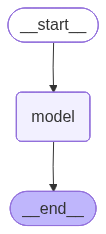

In [24]:
agent

In [25]:
query = "What is task decomposition?"
for step in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is task decomposition?


Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=019afeb1-be0d-7e30-bc9f-719012f3ec9d,id=019afeb1-be0d-7e30-bc9f-719012f3ec9d; trace=019afeb1-be0d-7e30-bc9f-719012f3ec9d,id=019afeb1-be15-77f3-a4c1-b06da6a4f517; trace=019afeb1-be0d-7e30-bc9f-719012f3ec9d,id=019afeb1-be4e-7103-b99c-7a68cb9fd2bb


================================== Ai Message ==================================

**Answer**

Task decomposition is the process of breaking a complex, high‑level goal into a set of smaller, more manageable sub‑tasks or steps. By dividing a big problem into simpler pieces, an agent (human or AI) can plan, reason, and execute each part more effectively, often improving overall performance and interpretability.

---

### How I arrived at this answer  

**User Input:**  
*“What is task decomposition?”*

**Task Planning:**  
I identified a single, straightforward information‑retrieval task:

| Task ID | Task Type          | Dependencies | Arguments                     |
|--------|--------------------|--------------|------------------------------|
| T1     | Explain concept    | –            | “task decomposition” definition |

**Model Selection:**  
Because the request only needs a concise, factual explanation, I assigned the task to a **language‑model expert** specialized in knowledge retr

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=019afeb1-be0d-7e30-bc9f-719012f3ec9d,id=019afeb1-be4e-7103-b99c-7a68cb9fd2bb; trace=019afeb1-be0d-7e30-bc9f-719012f3ec9d,id=019afeb1-be15-77f3-a4c1-b06da6a4f517; trace=019afeb1-be0d-7e30-bc9f-719012f3ec9d,id=019afeb1-be0d-7e30-bc9f-719012f3ec9d
